[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of tricks for trimming or filtering messages in graph state. 

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases. 

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_mistralai

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [10]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [11]:
# pull file if it doesn't exist and connect to local db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [12]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

In [ ]:
from langchain_mistralai import ChatMistralAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatMistralAI(model="mistral-large-latest",temperature=0)

class State(MessagesState):
    summary: str

def call_model(state: State):
    
    summary = state.get("summary", "")

    if summary:
        
        system_message = f"Summary of conversation earlier: {summary}"

        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    summary = state.get("summary", "")

    if summary:
        
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    if len(messages) > 4:
        return "summarize_conversation"
    
    return END

Now, we just re-compile with our sqlite checkpointer.

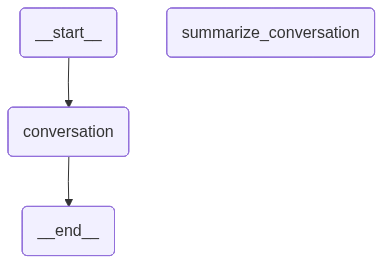

In [14]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times.

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="What do you think is John Mayer's best guitar solo of all time?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="It's a tough call. For me, it's probably the solo in 'Slow Dancing in a Burning Room' for its emotional depth.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What about his blues influence? Which blues guitarist do you think shaped his style the most?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I agree, Stevie Ray Vaughan's influence is undeniable. You can hear it in John's tone and phrasing.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Looking at his discography, which album are you most excited to revisit?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Continuum is always a masterpiece! The production and songwriting on that album are incredible.")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

The question of John Mayer's greatest guitar solo is highly subjective and often sparks passionate debates among fans and musicians. Some of the most frequently cited solos include:

1. **"Slow Dancing in a Burning Room"**: Praised for its emotional depth and melodic phrasing, this solo showcases Mayer's ability to convey profound feeling through his guitar work.

2. **"Gravity"**: Known for its sustained notes, masterful bends, and bluesy expression, this solo demonstrates both technical skill and emotional storytelling.

3. **"Bold as Love" (Jimi Hendrix cover)**: Mayer's interpretation of this Hendrix classic highlights his versatility and deep respect for blues and rock traditions.

4. **"Vultures"**: From his work with the John Mayer Trio, this solo showcases his raw blues chops and ability to channel classic blues masters.

5. **"Stop This Train"**: A more intimate, fingerpicked solo that demonstrat

Let's confirm that our state is saved locally.

In [16]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='Looking ahead, which circuit are you most excited for in the rest of the season?', additional_kwargs={}, response_metadata={}, id='1941f195-8f9e-440c-80e3-d92178647f74'), AIMessage(content="Looking ahead, there are several exciting circuits on the Formula 1 calendar, each offering unique challenges and thrilling racing. One circuit that often stands out is the **Circuit of the Americas (COTA)** in Austin, Texas. It's known for its diverse layout, featuring a mix of high-speed straights, technical sections, and elevation changes. The atmosphere is always electric, and the track tends to produce exciting races with plenty of overtaking opportunities.\n\nAnother highly anticipated race is the **Brazilian Grand Prix at Interlagos**. This circuit is renowned for its passionate fans and unpredictable weather, which can lead to dramatic and memorable races. The track's layout, with its mix of fast corners and elevation changes, often re

### Persisting state

Using database like Sqlite means state is persisted! 

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.

In [ ]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='Looking ahead, which circuit are you most excited for in the rest of the season?', additional_kwargs={}, response_metadata={}, id='1941f195-8f9e-440c-80e3-d92178647f74'), AIMessage(content="Looking ahead, there are several exciting circuits on the Formula 1 calendar, each offering unique challenges and thrilling racing. One circuit that often stands out is the **Circuit of the Americas (COTA)** in Austin, Texas. It's known for its diverse layout, featuring a mix of high-speed straights, technical sections, and elevation changes. The atmosphere is always electric, and the track tends to produce exciting races with plenty of overtaking opportunities.\n\nAnother highly anticipated race is the **Brazilian Grand Prix at Interlagos**. This circuit is renowned for its passionate fans and unpredictable weather, which can lead to dramatic and memorable races. The track's layout, with its mix of fast corners and elevation changes, often re

## LangGraph Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.